# ResNet vs ResNetAttention

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

sys.path.append('..')
sys.path.append('../task_02')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import ResNetAttention56, ResNet50
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted       # plot functions to demonstrate result 

In [2]:
IMAGE_SIZE = 128     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 64     # batch size for NN training
MAX_ITER = 1000      # number of iterations for NN training

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 180    # number of noise fragments per image  
size = 6            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

Extracting C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzExtractingExtracting
  Extracting C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz




In [5]:
load_template = (Pipeline()
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .make_masks()                     # create mask for MNIST image location
                 .create_noise('mnist_noise', level, n_fragments, size, distr)
                 .add_noise())

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'classes': 10,
                                  'dtype': 'int32',
                                  'transform': 'ohe',
                                  'name': 'targets'}
                       }

In [7]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'loss': 'softmax_cross_entropy',
                'output': {'ops': ['proba', 'accuracy']},
                'head/units': [100, 100, 2],
                'optimizer': 'Adam'}

train_feed_dict = {'images': B('images'),
                   'labels': B('labels')}        

test_feed_dict = {'images': B('images'),
                  'labels': B('labels')}

In [8]:
def test_model(model, n_iter):
    train_pp = ((load_template << mnistset.train)
                .init_model('static', model, 'model', config=model_config)
                .init_variable('loss', init_on_each_run=list)
                .train_model('model', fetches=['loss'], feed_dict=train_feed_dict, save_to=V('loss'), mode='e'))

    test_pp = ((load_template << mnistset.test)
                .import_model('model', train_pp)
                .init_variable('predicted_labels', init_on_each_run=list)
                .init_variable('acc', init_on_each_run=list)
                .predict_model('model', 
                               fetches=['predicted_labels', 'accuracy'], 
                               feed_dict=test_feed_dict, 
                               save_to=[V('predicted_labels'), V('acc')], 
                               mode='a'))

    iter_time = []
    for i in range(n_iter):
        start = time()
        train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
        iter_time.append(time()-start)
        batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
        acc = test_pp.get_variable('acc')
        loss = train_pp.get_variable('loss')
        clear_output(True)
        plt.figure(figsize=(30, 10))
        plt.subplot(1, 2, 1)
        plt.plot(loss)
        plt.title('Train loss')
        plt.subplot(1, 2, 2)
        plt.plot(acc)
        plt.title('Test accuracy')
        plt.show()

    print("Time per iter: {} sec".format(np.mean(iter_time)))
    return loss, acc, np.mean(iter_time)

### ResNet50 training time

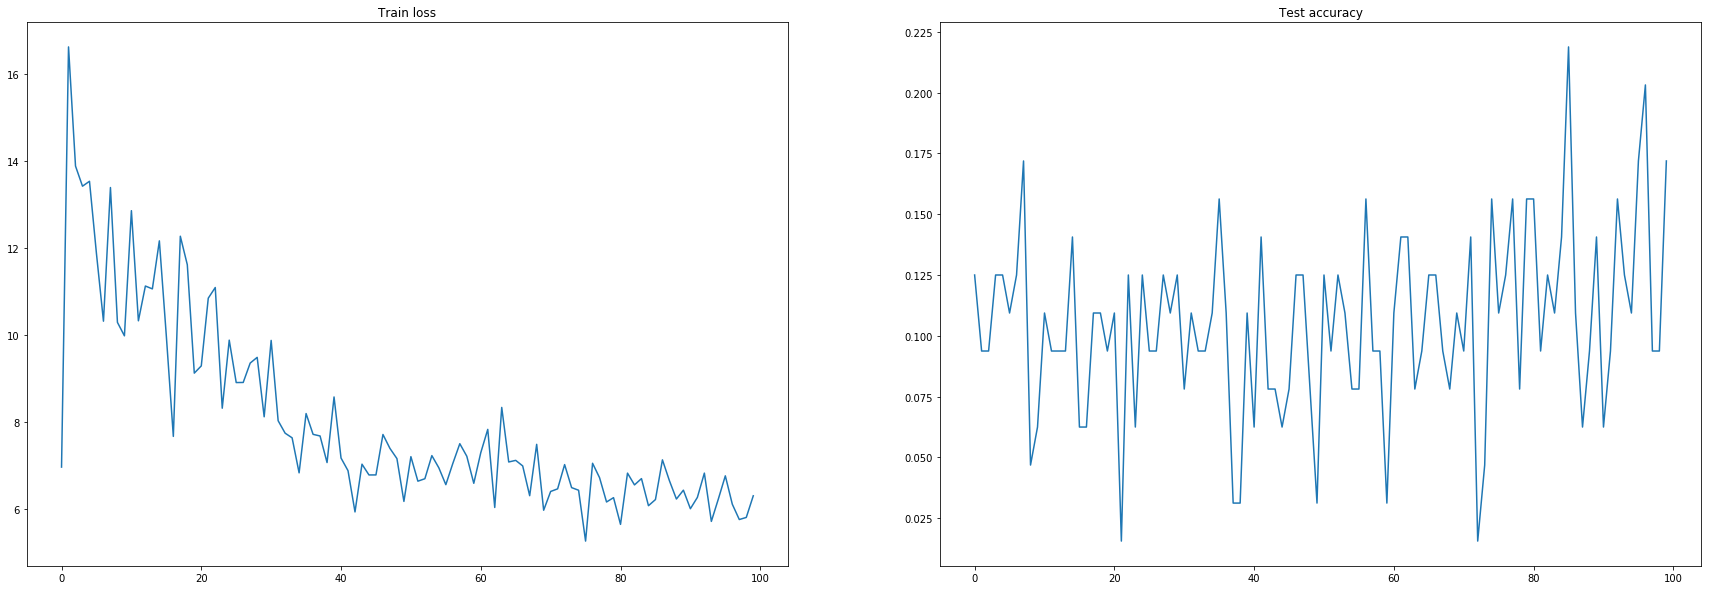

Time per iter: 1.3323246335983276 sec


In [9]:
_ = test_model(ResNet50, 100)

### ResNetAttention56 training time

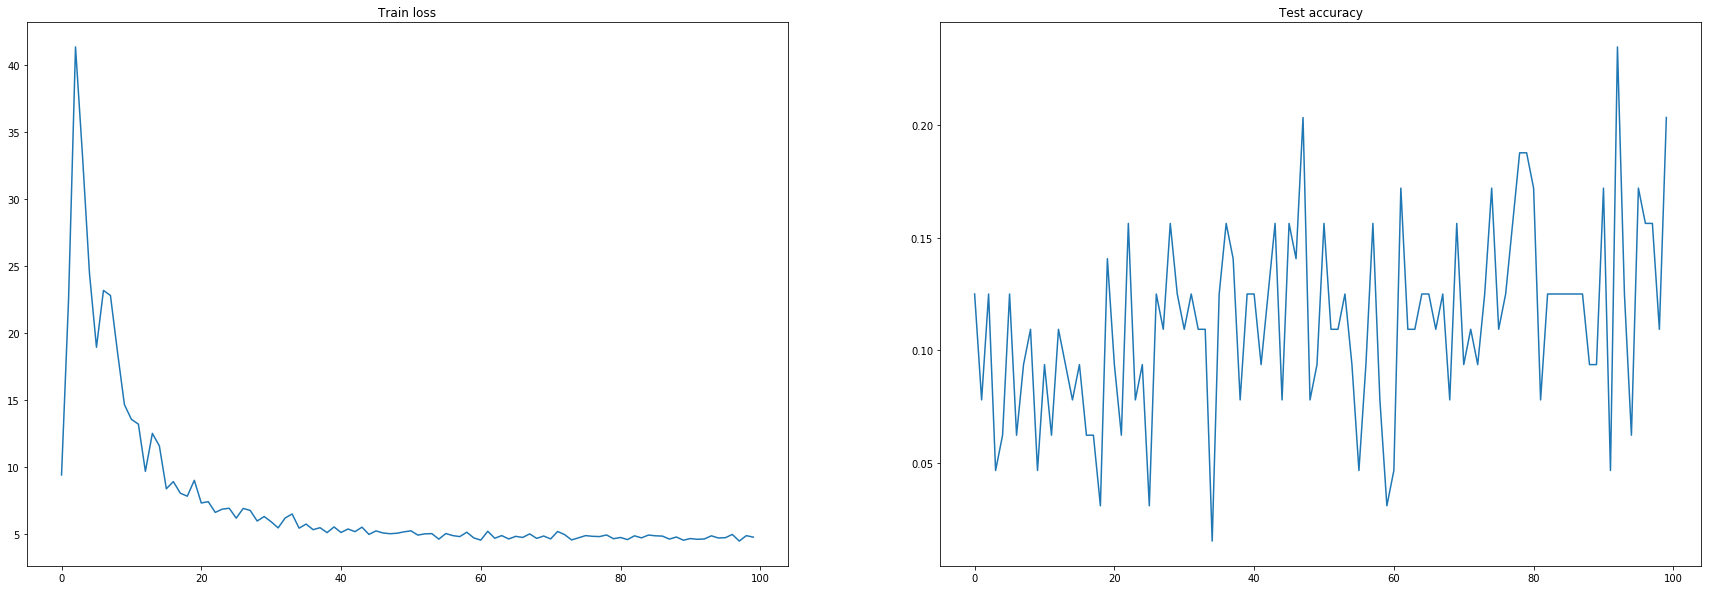

Time per iter: 1.3123407244682312 sec


In [10]:
_ = test_model(ResNetAttention56, 100)

### ResNet50 training

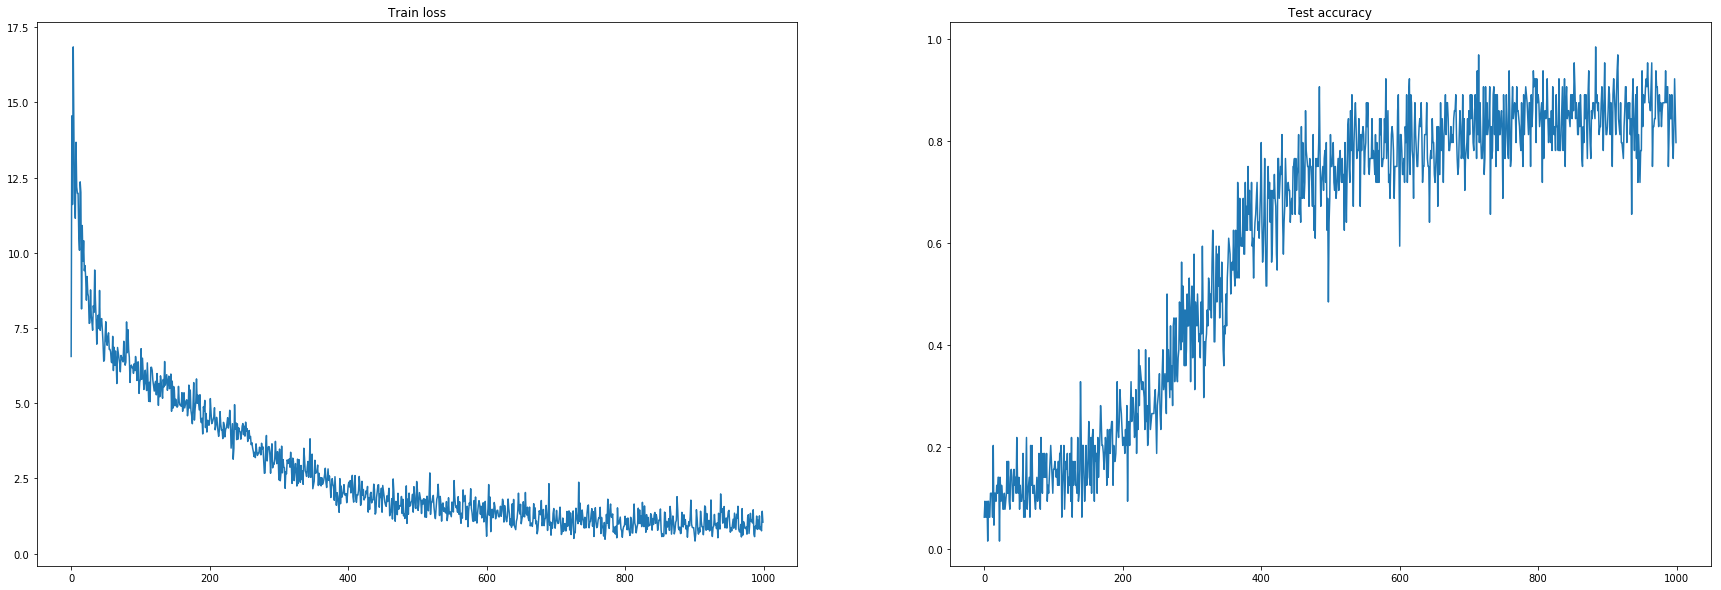

Time per iter: 1.3125640485286714 sec


In [11]:
resnet = test_model(ResNet50, MAX_ITER)

### ResNetAttention56 training

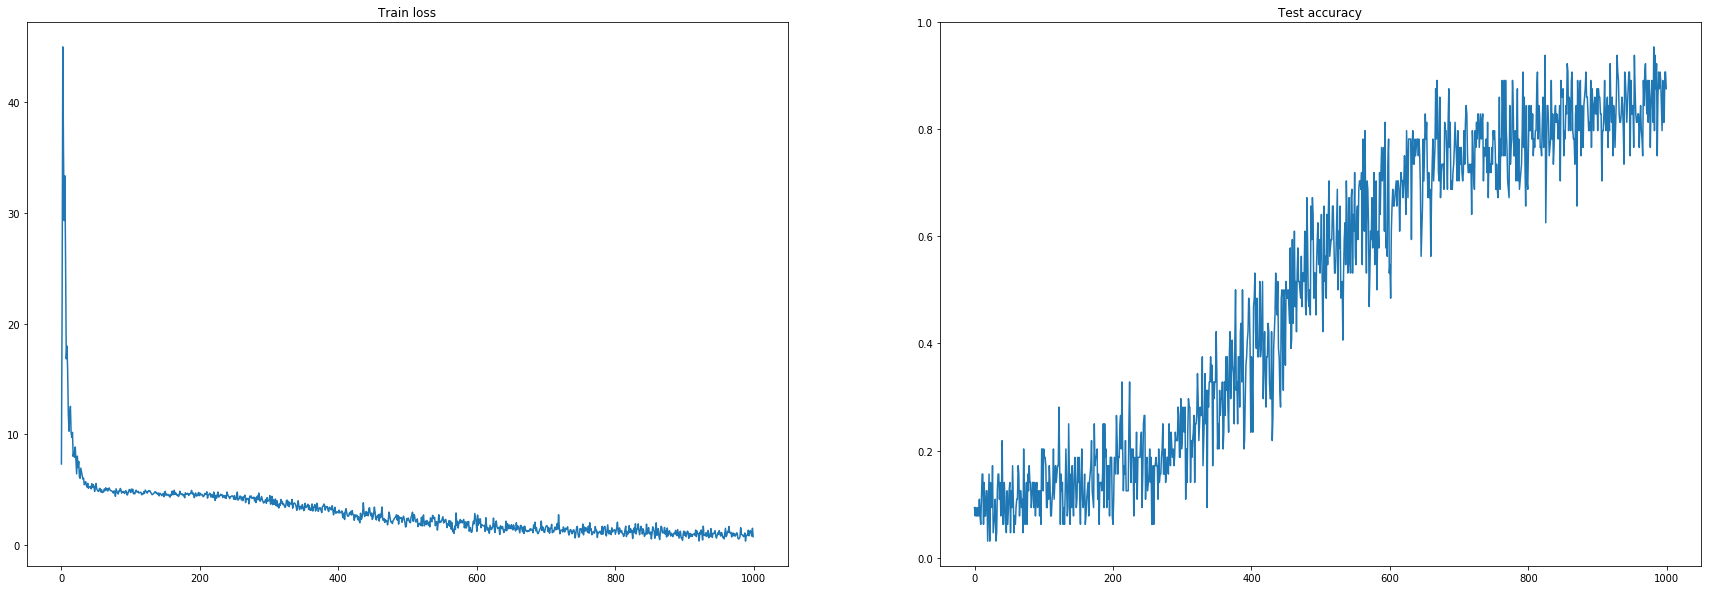

Time per iter: 1.2641959333419799 sec


In [12]:
resnetattention = test_model(ResNetAttention56, MAX_ITER)

In [28]:
def smooth(y, window=30, momentum=1):
    def _ma(y, window, momentum):
        momentum = np.float32(momentum)
        window = min(window, len(y))
        weights = momentum ** np.arange(-window+1, 1)
        return sum(y[-window:] * weights) / sum(weights)
    res = []
    for i, value in enumerate(y):
        res.append(_ma(y[:i+1], window, momentum))
    return np.array(res)

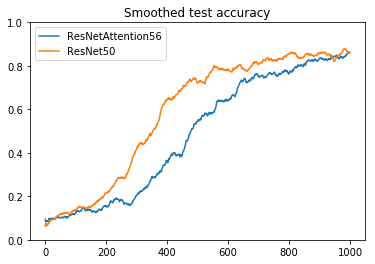

In [55]:
plt.title('Smoothed test accuracy')
plt.plot(smooth(resnetattention[1]), label='ResNetAttention56')
plt.plot(smooth(resnet[1]), label='ResNet50')
plt.ylim((0,1))
plt.legend()
plt.show()

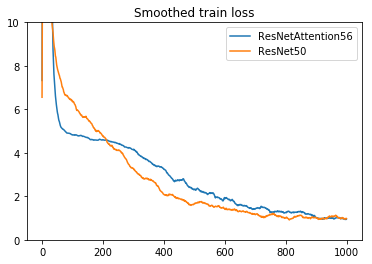

In [56]:
plt.title('Smoothed train loss')
plt.plot(smooth(resnetattention[0]), label='ResNetAttention56')
plt.plot(smooth(resnet[0]), label='ResNet50')
plt.ylim((0,10))
plt.legend()
plt.show()

In [58]:
level = 0.85
x = np.where(smooth(resnetattention[1]) > level)[0][0] * resnetattention[2]
print("ResNetAttention56: Accuracy became {} after {:4.2f} mins".format(level, x/60))
x = np.where(smooth(resnet[1]) > level)[0][0] * resnetattention[2]
print("ResNet50: Accuracy became {} after {:4.2f} mins".format(level, x/60))

ResNetAttention56: Accuracy became 0.85 after 20.86 mins
ResNet50: Accuracy became 0.85 after 16.73 mins
